In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys

In [12]:
#motorstroom = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[6, 7])
#motorstroom.to_pickle('switch01_motorstroom.pickle')
motorstroom = pd.read_pickle('switch01_motorstroom.pickle')

# controle_links = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[0, 1])
# controle_links.to_pickle('switch01_controle_links.pickle')
controle_links = pd.read_pickle('switch01_controle_links.pickle')

# controle_rechts = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[3, 4])
# controle_rechts.to_pickle('switch01_controle_rechts.pickle')
controle_rechts = pd.read_pickle('switch01_controle_rechts.pickle')

#sturing_links = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[9, 10])
#sturing_links.to_pickle('switch01_sturing_links.pickle')
sturing_links = pd.read_pickle('switch01_sturing_links.pickle')

#sturing_rechts = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[12, 13])
#sturing_rechts.to_pickle('switch01_sturing_rechts.pickle')
sturing_rechts = pd.read_pickle('switch01_sturing_rechts.pickle')

motorstroom_ = motorstroom.values
sturing_links_ = sturing_links.values
sturing_rechts_ = sturing_rechts.values
controle_links_ = controle_links.values
controle_rechts_ = controle_rechts.values

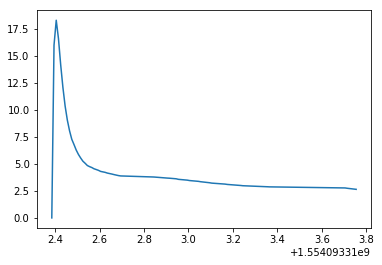

In [6]:
# quick sanity check

N = 50

plt.figure()
plt.plot([t.timestamp() for t in motorstroom.values[:N, 0]], motorstroom.values[:N, 1])
plt.show()

In [43]:
# detect individual switching events

def detect_events():
    events = []
    last_begin = None

    row_l = 0
    row_r = 0

    while row_l < len(sturing_links) and row_r < len(sturing_rechts):
        # compare next timestamps of both
        ts_l = sturing_links_[row_l,0]
        ts_r = sturing_rechts_[row_r,0]
        #print(ts_l, ts_r, row_l, row_r)

        if ts_l < ts_r:
            # did it actually change?
            if row_l > 0 and sturing_links_[row_l,1] != sturing_links_[row_l - 1,1]:
                # yay!
                events += [(ts_l, 'LEFT', sturing_links_[row_l, 1])]
            row_l += 1
        else:
            # did it actually change?
            if row_r > 0 and sturing_rechts_[row_r,1] != sturing_rechts_[row_r - 1,1]:
                # yay!
                events += [(ts_r, 'RIGHT', sturing_rechts_[row_r, 1])]
            row_r += 1

    return events

%time events = detect_events()
events

CPU times: user 1.84 s, sys: 48.5 ms, total: 1.89 s
Wall time: 1.92 s


[(Timestamp('2019-04-01 04:35:12.362000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 04:35:15.212000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 04:43:32.921000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 04:43:35.771000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:00:56.079000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:00:58.929000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:05:10.378000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 05:05:13.178000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 05:14:55.036000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:14:57.836000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:27:09.846000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 05:27:12.646000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 05:35:21.395000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:35:24.195000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:37:45.544000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 05:37:48.344000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 05:44:31.004000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-0

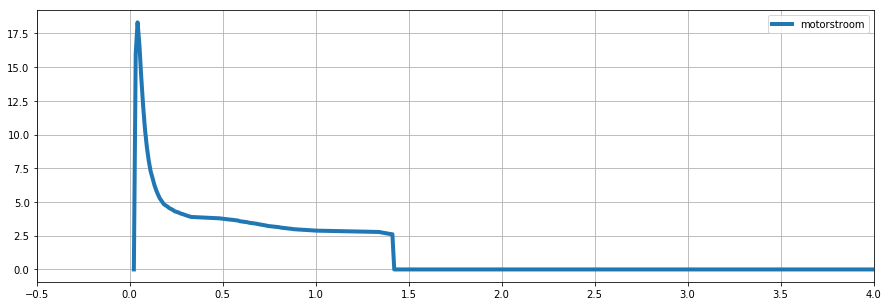

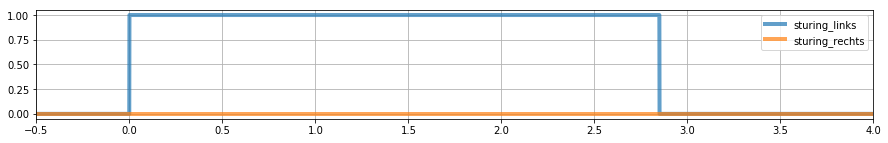

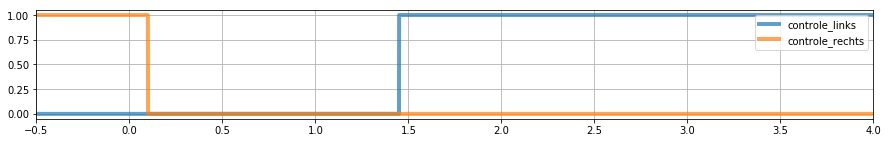

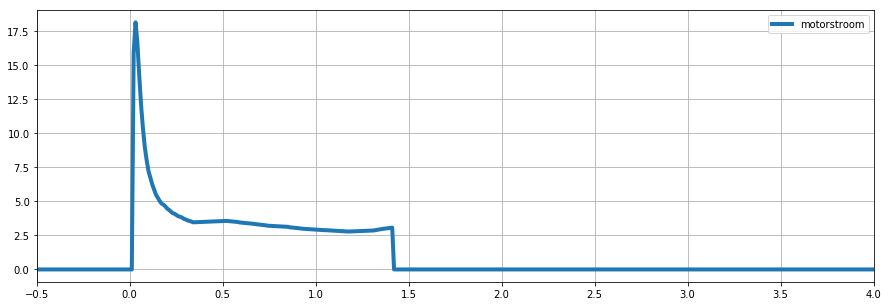

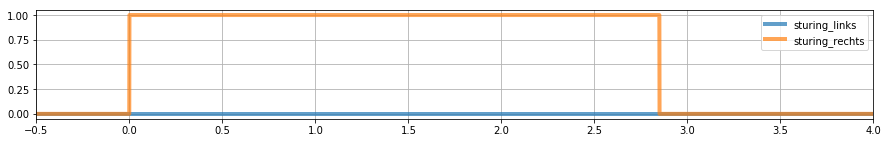

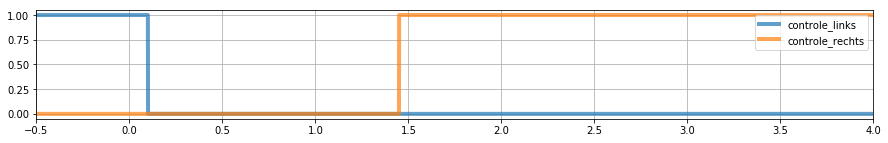

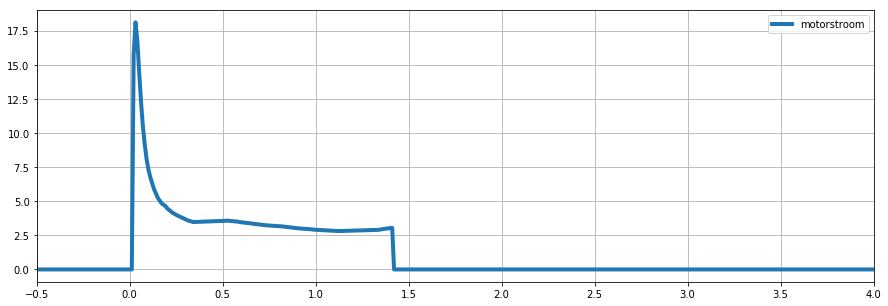

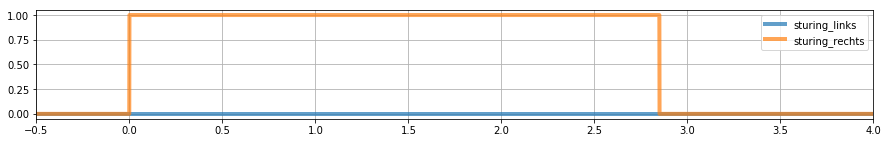

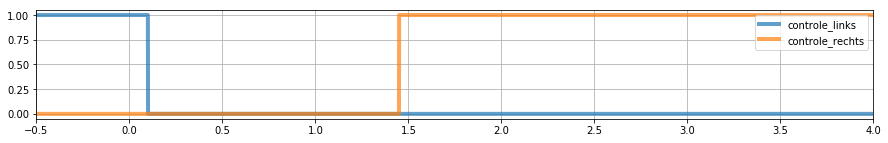

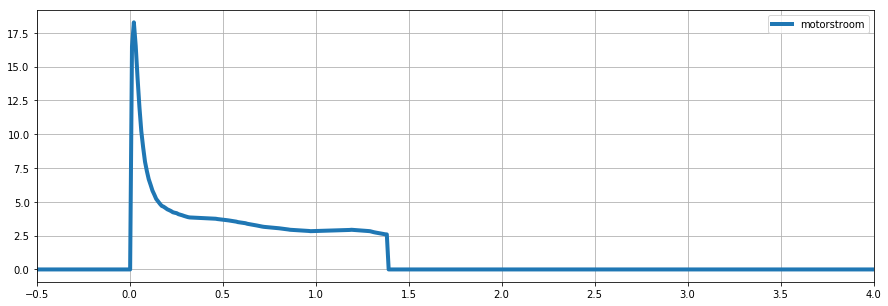

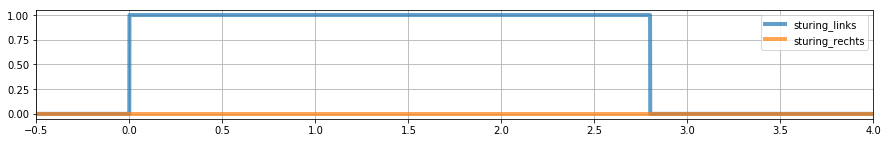

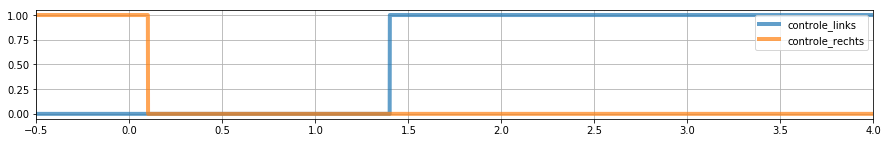

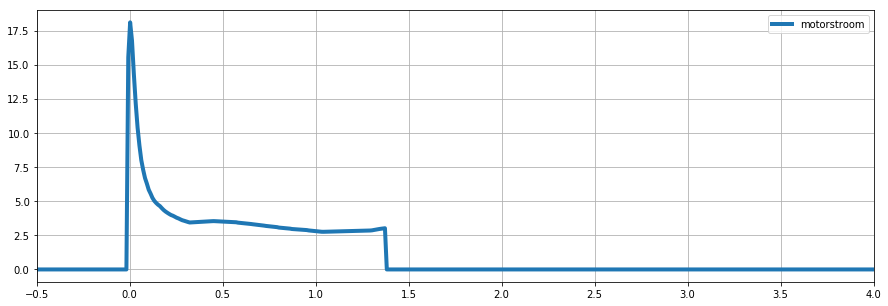

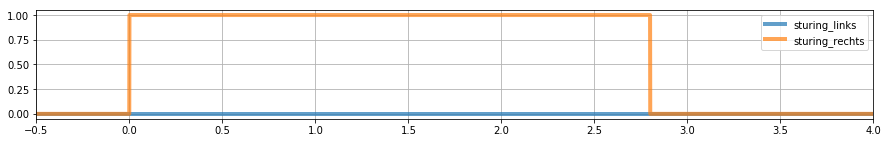

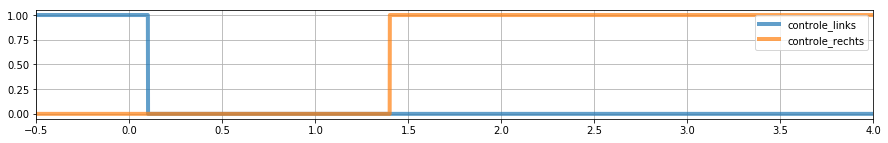

In [104]:
import datetime

def data_for_period(table, start, origin, end):
    start_index = max(0, np.argmax(table[:,0] > start) - 1)
    end_index = np.argmax(table[:,0] >= end) + 1

#     print('SPAN', start_index, end_index)
    cutout = np.copy(table[start_index:end_index])
    #t[:,0] = [(y - start).seconds for y in t[:,0]]
    #print(table.shape)
    t = np.zeros(cutout.shape)
    #print([(y - start) for y in cutout[:,0]])
    t[:,0] = [(y - origin).total_seconds() for y in cutout[:,0]]
    t[:,1] = cutout[:,1]
    #t = np.vstack([[(y - start).seconds for y in table[:,0]], table[:,1]])
    #print(t.shape)
    return t

def zero_order_hold(matrix):
    neue = np.zeros((matrix.shape[0] * 2 - 1, matrix.shape[1]))

    neue[::2,:]   = matrix[:,:]     # plain copy every even row
    neue[1::2,0]  = matrix[1:,0]-0.001    # copy timestamp for every odd row except the first and subtract
    neue[1::2,1:] = matrix[:matrix.shape[0]-1,1:]         # copy data for every even row except the last

    return neue

def visualize_event(starttime_in):
    starttime = starttime_in - datetime.timedelta(seconds=0.5)
    endtime = starttime_in + datetime.timedelta(seconds=4)

    def pltopts():
        plt.grid(which='both')
        plt.legend()
        #plt.xlim([starttime, endtime])
        plt.xlim([-0.5, 4])

    #print('Timespan: ', motorstroom_period.values[-1,0] - motorstroom_period.values[0,0])
    plt.figure(figsize=(15, 5))

    motorstroom_period = data_for_period(motorstroom_, starttime, starttime_in, endtime)
    #print(motorstroom_period)
    plt.plot(motorstroom_period[:,0], motorstroom_period[:,1], label='motorstroom', linewidth=4)

    pltopts()
    
    plt.figure(figsize=(15, 2))

    sturing_links_period = zero_order_hold(data_for_period(sturing_links_, starttime, starttime_in, endtime))
    plt.plot(sturing_links_period[:,0], sturing_links_period[:,1], alpha=0.7, label='sturing_links', linewidth=4)
    #print(sturing_links_period[0:5])

    sturing_rechts_period = zero_order_hold(data_for_period(sturing_rechts_, starttime, starttime_in, endtime))
    plt.plot(sturing_rechts_period[:,0], sturing_rechts_period[:,1], alpha=0.7, label='sturing_rechts', linewidth=4)

    pltopts()

    plt.figure(figsize=(15, 2))

    controle_links_period = zero_order_hold(data_for_period(controle_links_, starttime, starttime_in, endtime))
    plt.plot(controle_links_period[:,0], controle_links_period[:,1], alpha=0.7, label='controle_links', linewidth=4)

    controle_rechts_period = zero_order_hold(data_for_period(controle_rechts_, starttime, starttime_in, endtime))
    plt.plot(controle_rechts_period[:,0], controle_rechts_period[:,1], alpha=0.7, label='controle_rechts', linewidth=4)

    pltopts()

for when, what, val in events[0:10]:
    if val > 0.5:
        visualize_event(when)

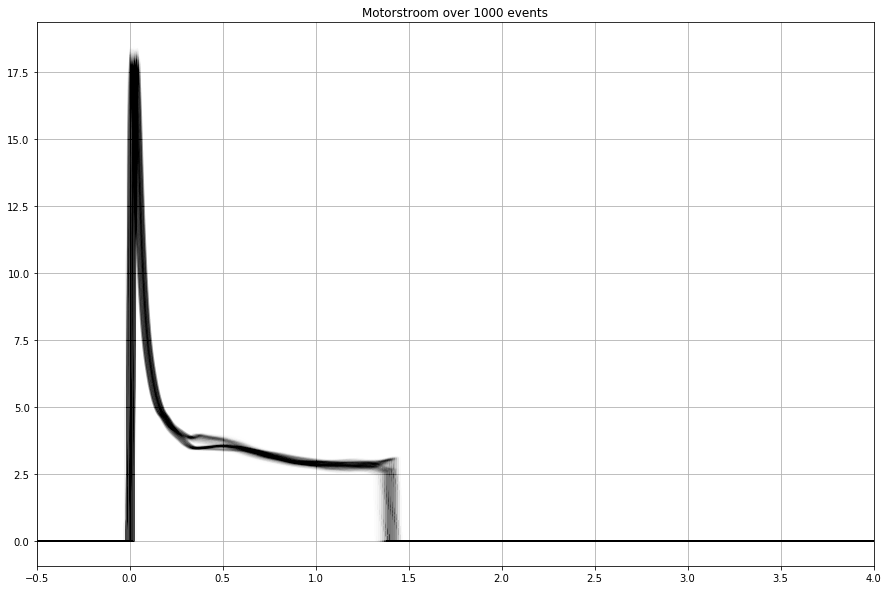

In [102]:
def visualize_event2(starttime_in):
    starttime = starttime_in - datetime.timedelta(seconds=0.5)
    endtime = starttime_in + datetime.timedelta(seconds=4)

    motorstroom_period = data_for_period(motorstroom_, starttime, starttime_in, endtime)
    #print(motorstroom_period)
    plt.plot(motorstroom_period[:,0], motorstroom_period[:,1], linewidth=2, color=(0,0,0), alpha=0.002)

plt.figure(figsize=(15,10))

count = 0

for when, what, val in events[0:2000]:
    if val > 0.5:
        visualize_event2(when)
        count += 1

plt.grid(which='both')
plt.xlim([-0.5, 4])
plt.title('Motorstroom over ' + str(count) + ' events')
plt.savefig('1000events.png')